### Basic Nerual Network
Followed tutioral from:
https://www.youtube.com/watch?v=VMj-3S1tku0&t=2143s&ab_channel=AndrejKarpathy

In [1]:
#Libraries to be install
import numpy as np
import math
import graphviz as gv
from graphviz import Digraph
import random
import time
import matplotlib.pyplot as plt
random.seed(42)

In [2]:
class perceptron:
    def __init__(self, x):
        self.value = 0.0 + x
        self.children = []
        self.parents = []

    def add_child(self, child):
        self.children.append(child)
        child.parents.append([self, random.uniform(-1,1)])

In [3]:
class nerualNetwork:
    def __init__(self, numIn, numLayers, numOut, actFunc, lossFunc, bias):
        self.numIn = numIn
        self.numLayers = numLayers 
        self.numOut = numOut
        self.inputs = []
        self.outputs = []
        self.actFunc = actFunc
        self.lossFunc = lossFunc
        self.bias = bias
        self.construct()

    def copy(self):
        import copy
        return copy.deepcopy(self)
    
    def construct(self):
        def create_nodes(num):
            return [perceptron(0) for _ in range(num)]

        def connect(lstOne, lstTwo):
            for node1 in lstOne:
                for node2 in lstTwo:
                    node1.add_child(node2)
            return lstOne

        self.inputs = create_nodes(self.numIn)
        self.outputs = create_nodes(self.numOut)

        layers = [create_nodes(n) for n in self.numLayers]

        if len(layers) == 0:
            connect(self.inputs, self.outputs)
        else:
            connect(self.inputs, layers[0])
            for i in range(len(layers) - 1):
                connect(layers[i], layers[i+1])
            connect(layers[-1], self.outputs)

    def print_weights(self):
        print("Weights from inputs to hidden layer:")
        for node in self.inputs:
            for child in node.children:
                weight = [parent[1] for parent in child.parents if parent[0] == node][0]
                print(weight)  # print weight

        print("Weights from hidden layer to output layer:")
        for node in self.outputs:
            for parent in node.parents:
                print(parent[1])  # print weight

    def forwardProp(self, inpts, labels):
        for i in range(len(self.inputs)):
            self.inputs[i].value = inpts[i]
            
        def DFS_forward(node):
            # Get list of the current children
            lstChildren = node.children #[sublist[0] for sublist in node.children]
            # Print the child Val & Grad and decend back down
            for child in lstChildren:
                values = [sublist[0].value for sublist in child.parents]
                weights = [sublist[1] for sublist in child.parents]
                x = np.dot(values, weights) #+ self.bias
                if self.actFunc == "Sigmoid":
                    x = 1 / (1 + np.exp(-x))
                elif self.actFunc == "ReLU":
                    x = np.maximum(0, x)
                elif self.actFunc == "Softplus":
                    x = np.log(1 + np.exp(x))
                child.value = x
                DFS_forward(child)

        for n in self.inputs:
            DFS_forward(n)
        
        loss = 0
        # Calculate loss
        if self.lossFunc == "CrossEntropy":
            # Binary Cross-Entropy Loss
            loss = [-label[0] * np.log(output.value + 1e-7) - (1 - label[0]) * np.log(1 - output.value + 1e-7) 
                    for output, label in zip(self.outputs, labels)]
        elif self.lossFunc == "MSE":
            # # Mean Squared Error Loss
            # for outputx, labelx in zip(self.outputs, labels):
            #     print("HERE1",outputx.value )
            #     print("HERE2", labelx)

            loss = [0.5 * np.power((output.value - label[0]), 2)
                    for output, label in zip(self.outputs, labels)]
        
        return loss

    def backwardProp(self, labels, r):
        def DFS_backward(node, label, r):
            # Get list of the current children
            pairsParents = node.parents
            # Print the child Val & Grad and decend back down
            for pair in pairsParents:
                newWeight = 0
                a0 = node.value
                a1 = pair[0].value
                w = pair[1]
                grad = 0
                if self.actFunc == "Sigmoid": 
                    sigmoid_derivative = a0 * (1 - a0)
                    if self.lossFunc == "CrossEntropy":
                        grad = a0 - label
                    elif self.lossFunc == "MSE":
                        grad = 2 * (a0 - label)
                    newWeight = w - r * grad * sigmoid_derivative
                elif self.actFunc == "ReLU":
                    relu_derivative = np.where(a1 > 0, 1, 0)
                    if self.lossFunc == "CrossEntropy":
                        grad = a0 - label
                    elif self.lossFunc == "MSE":
                        grad = 2 * (a0 - label)
                    newWeight = w - r * grad * relu_derivative
                elif self.actFunc == "Softplus":
                    softplus_derivative = 1 / (1 + np.exp(-a1))
                    if self.lossFunc == "CrossEntropy":
                        grad = a0 - label
                    elif self.lossFunc == "MSE":
                        grad = 2 * (a0 - label)
                    newWeight = w - r * grad * softplus_derivative


                pair[1] = newWeight  # update weight

            # Check for numerical stability before updating bias
            parent_values = [pair[0].value for pair in pairsParents]
            if np.all(np.isfinite(parent_values)) and len(parent_values) != 0:
                self.bias -= r * np.mean(parent_values)

            for pair in pairsParents:
                DFS_backward(pair[0],label,r)

        # Compute the gradient of the loss function
        if self.lossFunc == "CrossEntropy":
            grad = [output.value - label for output, label in zip(self.outputs, labels)]
        elif self.lossFunc == "MSE":
            grad = [2 * (output.value - label) for output, label in zip(self.outputs, labels)]

        # Propagate the gradient back through the network
        for node, g in zip(self.outputs, grad):
            DFS_backward(node, g, r)
        
    def train(self, inputs, labels, r, epochs):
        loss_time_pairs = []
        start_time = time.time() * 1000  # record start time in milliseconds
        for _ in range(epochs):
            for input, label in zip(inputs, labels):
                loss = self.forwardProp(input, labels)
                elapsed_time_in_ms = time.time() * 1000 - start_time  # calculate elapsed time
                loss_time_pairs.append((loss, elapsed_time_in_ms))
                self.backwardProp(label, r)
        return loss_time_pairs

    def predict(self, inputs):
        self.forwardProp(inputs,[])
        return [node.value for node in self.outputs]
    
    def trace(self):
        nodes, edges = set(), set()
        visited = set()

        def build(node):
            if node not in visited:
                visited.add(node)
                nodes.add(node)
                for child in node.children:
                    edges.add((child, node))
                    build(child)

        for root in self.inputs:
            build(root)

        return nodes, edges

    def draw_dot(self):
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

        nodes, edges = self.trace()
        for node in nodes:
            dot.node(name=str(id(node)), label=f"value: {node.value:.4f}", shape='circle')

        for child, parent in edges:
            weight = next(w for n, w in child.parents if n == parent)
            dot.edge(str(id(parent)), str(id(child)), label=f"w: {weight:.4f}")

        return dot
        

In [4]:
# Graphing Function
def trace(roots):
    nodes, edges = set(), set()
    visited = set()

    def build(v):
        if v not in visited:
            visited.add(v)
            nodes.add(v)
            for child in reversed(v.children):
                edges.add((child, v))
                build(child)

    for root in roots:
        build(root)

    return nodes, edges

def draw_dot(roots):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(roots)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="value: %.4f" % (n.value), shape='circle', width='1.0', height='1.0')
    x = 1
    for n1, n2 in edges:
        
        # connect n1 to n2
        weights1 = [sublist[1] for sublist in n1.parents]
        nodeP1 = [sublist[0] for sublist in n1.parents]
        weight = 0
        for index, parent in enumerate(nodeP1):
            if parent == n2:
                weight = weights1[index]

        edge_label = "w: %.4f" % weight
        dot.edge(str(id(n2)), str(id(n1)), label=edge_label)
        x+=1

    return dot

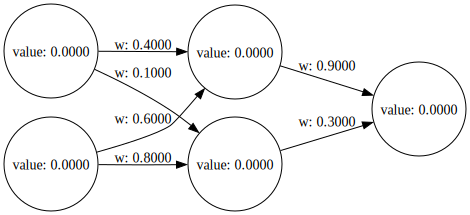

In [5]:
NN = nerualNetwork(2,[2],1,"Sigmoid","MSE",0)
x = 0.8
NN.inputs[0].children[0].parents[0][1] = 0.1
NN.inputs[0].children[0].parents[1][1] = 0.8
NN.inputs[0].children[1].parents[0][1] = 0.4
NN.inputs[0].children[1].parents[1][1] = 0.6
NN.inputs[0].children[0].children[0].parents[0][1] = 0.3
NN.inputs[0].children[0].children[0].parents[1][1] = 0.9
draw_dot(NN.inputs)



[]


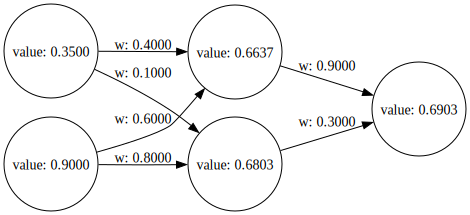

In [6]:
print(NN.forwardProp([0.35,0.9],[]))
draw_dot(NN.inputs)

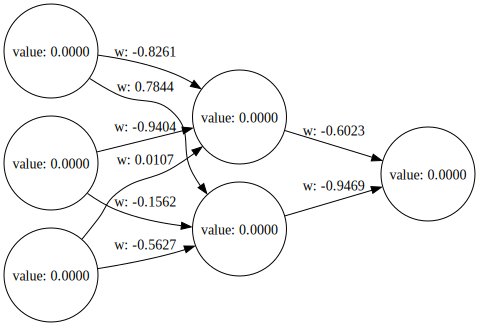

In [7]:
ANDgateModel = nerualNetwork(3,[2],1,"Sigmoid","CrossEntropy",1)
draw_dot(ANDgateModel.inputs)

Weights from inputs to hidden layer:
0.7843591354096908
-0.8261223347411677
-0.15615636062945915
-0.9404055611238593
-0.5627240503927933
0.010710576206724776
Weights from hidden layer to output layer:
-0.9469280606322728
-0.602324698626703


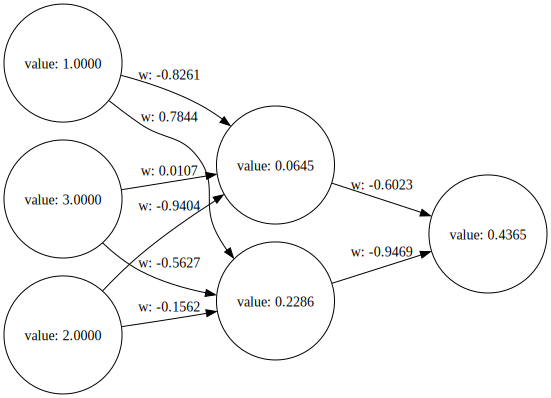

In [48]:
CustomNN = ANDgateModel.copy()
CustomNN.print_weights()
CustomNN.forwardProp([1, 2, 3],[[0]])
CustomNN.draw_dot()

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

bias = 0
# Inputs
x1, x2, x3 = 1, 0, 1

# Weights to hidden layer
w21 =0.7843591354096908
w22 = -0.8261223347411677
w31 = -0.15615636062945915
w32 = -0.9404055611238593
w11 =-0.5627240503927933
w12 =0.010710576206724776

# Weights to output layer
v1 =-0.9469280606322728
v2 =-0.602324698626703

# Learning rate
lr = 0.1

# Calculate hidden layer values
z1 = w11*x1 + w21*x2 + w31*x3 + bias
h1 = sigmoid(z1)
print("h1: ", h1)

z2 = w12*x1 + w22*x2 + w32*x3 + bias
h2 = sigmoid(z2)
print("h2: ", h2)

# Calculate output value
z3 = v1*h1 + v2*h2
y = sigmoid(z3)

print('Output from forward propagation:', y)

# Assume t is the target output
t = 0

# Calculate output error
delta_y = (y - t) * sigmoid_derivative(y)

# Update weights from hidden layer to output layer
v1 -= lr * delta_y * h1
v2 -= lr * delta_y * h2

# Calculate hidden layer errors
delta_h1 = delta_y * v1 * sigmoid_derivative(h1)
delta_h2 = delta_y * v2 * sigmoid_derivative(h2)

# Update weights from input to hidden layer
w11 -= lr * delta_h1 * x1
w21 -= lr * delta_h1 * x2
w31 -= lr * delta_h1 * x3

w12 -= lr * delta_h2 * x1
w22 -= lr * delta_h2 * x2
w32 -= lr * delta_h2 * x3

print('Updated weights from input to hidden layer:', w11, w21, w31, w12, w22, w32)
print('Updated weights from hidden layer to output layer:', v1, v2)



h1:  0.3276395716853663
h2:  0.28298659955175
Output from forward propagation: 0.382086626256674
Updated weights from input to hidden layer: -0.5608364059812956 0.7843591354096908 -0.15426871621796143 0.011817739916365935 -0.8261223347411677 -0.9392983974142182
Updated weights from hidden layer to output layer: -0.9498836739727137 -0.6048775006722519


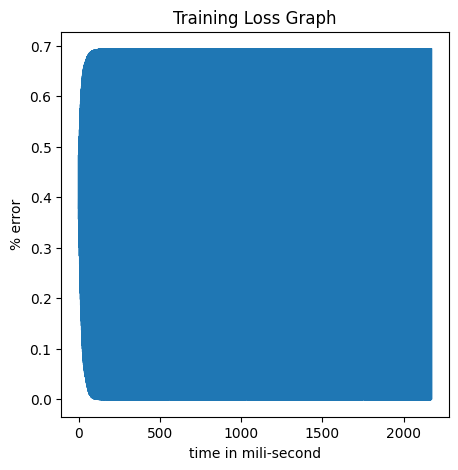

In [ ]:
xs = [
  [0, 0, 0],
  [0, 0, 1],
  [0, 1, 0],
  [0, 1, 1],
  [1, 0, 0],
  [1, 0, 1],
  [1, 1, 0],
  [1, 1, 1],
]
ys = [[0],[0],[0],[1],[1],[0],[0],[1]] # desired targets

xy = ANDgateModel.train(xs, ys, 0.1, 2000)

# Separate the loss and time values
x = [obj[1] for obj in xy]  # time values
y = [obj[0] for obj in xy]  # loss values

# Create the plot
fig, axs = plt.subplots(figsize=(5, 5))  # no need to specify 1, 1 for a single plot
axs.set_title('Training Loss Graph')
axs.set_ylabel('% error')
axs.set_xlabel('time in mili-second')
axs.plot(x, y)
plt.show()


Predict: 0.000, TrueVal: 0
Predict: 0.500, TrueVal: 0
Predict: 0.500, TrueVal: 0
Predict: 0.500, TrueVal: 1
Predict: 0.500, TrueVal: 1
Predict: 0.500, TrueVal: 0
Predict: 0.500, TrueVal: 0
Predict: 0.500, TrueVal: 1


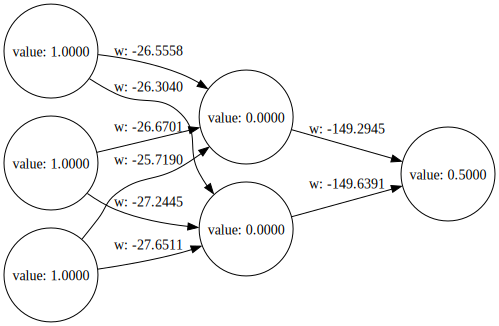

In [ ]:
for i in range(len(xs)):
    print('Predict: %0.3f, TrueVal: %d'%(ANDgateModel.predict(xs[i])[0], ys[i][0]))
draw_dot(ANDgateModel.inputs)


